# This code plots:

1. The temporal evolution of the flexural deflection and travel distance of the river mouth.
2. Wheeler diagrams, which show the changes in bathymetry through time for the flexurally compensated and non-flexurally compensated simulations. 

In [28]:
import numpy as np
import pandas as pd
# import bottleneck as bn
import scipy
from scipy.ndimage import gaussian_filter1d

import cmocean as cmo
import matplotlib as mpl
from matplotlib import mlab, cm
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import string


# Import the python file (.py) which contains all defined functions
import utils.stratalArchitecture as strata

# Display plots in SVG format
%config InlineBackend.figure_format = 'svg'

# Display plots in cells
%matplotlib inline

In [29]:
# Loading the files with the metrics e.g. flexure, accumulation
#Synthetic

Delta_SL0_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL0_Te50.csv',sep=',', header=0)
Delta_SL_f5Myr_A25m_Te50=pd.read_csv('extracted_results/Synthetic/Delta_SL_f5Myr_A25m_Te50.csv', sep=',',header=0)
Delta_SL_f500Kyr_A25m_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL_f500Kyr_A25m_Te50.csv',sep=',', header=0)
Delta_SL0_NoFlex=pd.read_csv ('extracted_results/Synthetic/Delta_SL0_NoFlex.csv',sep=',', header=0)
Delta_SL_f5Myr_A25m_NoFlex=pd.read_csv('extracted_results/Synthetic/Delta_SL_f5Myr_A25m_NoFlex.csv', sep=',',header=0)
Delta_SL_f500Kyr_A25m_NoFlex=pd.read_csv ('extracted_results/Synthetic/Delta_SL_f500Kyr_A25m_NoFlex.csv',sep=',', header=0)

#IH GH
Delta_SL_IH_Te50=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_IH_Te50.csv',sep=',', header=0)
Delta_SL_IH_NoFlex=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_IH_NoFlex.csv',sep=',', header=0)
Delta_SL_GH_Te50=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_GH_Te50_120820manual.csv',sep=',', header=0)
Delta_SL_GH_NoFlex=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_GH_NoFlex_120820manual.csv',sep=',', header=0)


#Loading the sea level curves
Delta_SL_f5Myr_A25m=pd.read_csv('../../2_model_running/data/f5Myr_A25m.csv', sep=' ',header=None)
Delta_SL_f500Kyr_A25m=pd.read_csv('../../2_model_running/data/f500Kyr_A25m.csv', sep=' ',header=None)
SL_IH=pd.read_csv('../../2_model_running/data/SL_IH.csv', sep=' ',header=None)
SL_GH=pd.read_csv('../../2_model_running/data/SL_GH.csv', sep=' ',header=None)

sea_level=(Delta_SL_f5Myr_A25m, Delta_SL_f500Kyr_A25m, SL_IH, SL_GH)

results_Te50=(Delta_SL0_Te50, Delta_SL_f5Myr_A25m_Te50, Delta_SL_f500Kyr_A25m_Te50, Delta_SL_IH_Te50, Delta_SL_GH_Te50)

results_NF=(Delta_SL0_NoFlex, Delta_SL_f5Myr_A25m_NoFlex, Delta_SL_f500Kyr_A25m_NoFlex, Delta_SL_IH_NoFlex, Delta_SL_GH_NoFlex)


# This function generates the wheeler diagrams

In [30]:
def enviID_WD(path):
    folder = path  # output folder path
    strat = strata.stratalSection(folder, 1)
    timestep = 119 
    strat.loadStratigraphy(timestep)  # load strata files
    strat.loadTIN(timestep)  # load TIN files
    
    cs=np.zeros((2,2))
    cs[0,:] = [200e4,100e4]  # point 1
    cs[1,:] = [300e4,100e4]  # point 2
    # Interpolation parameters
    nbpts = 500  
    gfilt = 1  
    # Build cross-section
    strat.buildSection(xo = cs[0,0], yo = cs[0,1], xm = cs[1,0], ym = cs[1,1], pts = nbpts, gfilter = gfilt)
    # Specify the range of water depth for the depositional environments, see the table above
    depthID = [0, -25, -100, -200,-500, -1000]
    enviID = np.zeros((strat.nz, len(strat.dist)))
    enviID = strata.buildEnviID(cs = strat, depthID = depthID)
    start_time = 0.  # the start time of the model run [a]
    # Time structure of the model, corresponding to the Time structure in the input.xml file
    disptime = 100000.  # the layer interval of the strata module [a]
    end_time = start_time + disptime * timestep  # the time of the loaded output [a]
    layertime = np.linspace(start_time,end_time,strat.nz)  # time of the layers
    return enviID, strat.dist, layertime

In [31]:
nfile=len(Delta_SL_IH_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100


In [32]:
path='/live/share/Badlands_simulations'
directory=path + '/Delta_2020/Delta_running/Synthetic/'
synthetic_freq_dir=['Delta_SL0_Te50/h5', 
                    'Delta_SL_f5Myr_A25m_Te50/h5',
                    'Delta_SL_f500Kyr_A25m_Te50/h5', 
                    'Delta_SL0_NoFlex/h5',
                    'Delta_SL_f5Myr_A25m_NoFlex/h5',
                    'Delta_SL_f500Kyr_A25m_NoFlex/h5']
synthetic_freq=[]
for i in np.arange(0,len(synthetic_freq_dir),1):
       synthetic_freq.append(str(directory)+str(synthetic_freq_dir[i]))
        
directory=path+'/Delta_2020/Delta_running/IH_GH/'
IH_GH_dir=[ 'Delta_SL_IH_Te50/h5', 
            'Delta_SL_GH_Te50_120820/h5', 
            'Delta_SL_IH_NoFlex/h5',
            'Delta_SL_GH_NoFlex_120820/h5']

IH_GH=[]

for i in np.arange(0,len(IH_GH_dir),1):
       IH_GH.append(str(directory)+str(IH_GH_dir[i]))


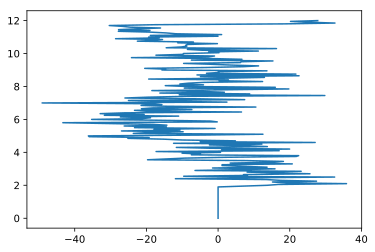

In [33]:
plt.plot(sea_level[2][1], sea_level[2][0]/1e6)

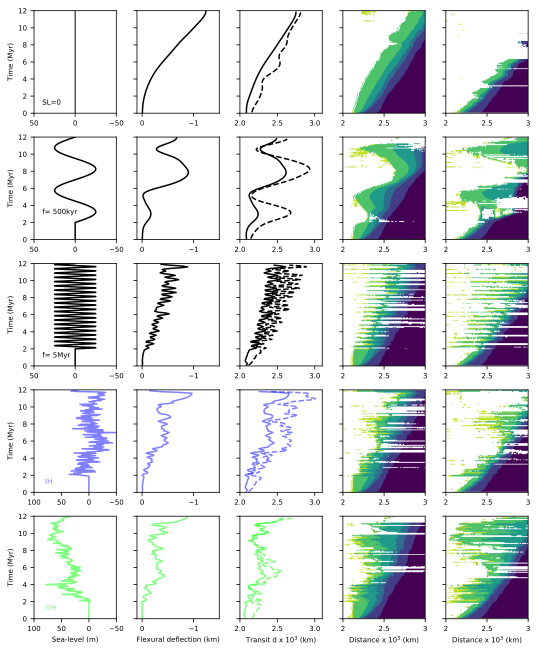

In [34]:
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
y_positions = np.arange(0,140,20) # pixel count at label position
y_labels = np.arange(0,14,2)# labels you want to see
x_positions=(0,250,500)
x_labels=(2,2.5,3)
depthID = [0, -25, -100, -200,-500, -1000]
colorss=[plt.cm.viridis(i) for i in np.linspace(0, 0.9, len(depthID))]#sample viridis
colorss_r=colorss[::-1]#Then reverse it because I want the green hues to represent shallow water
colorss_rw= colors.ListedColormap(np.vstack(((1,1,1,1), colorss_r)))#Then add white
ncols=5
nrows=5
lb=1
ub=-1
GH_color=(0,1,0,0.5)
IH_color=(0,0,1,0.5)
grey=(0.1,0.1,0.1,0.5)

color_lines=['k', 'k', 'k', IH_color, GH_color]
sigma=[6,4,1,1,1]
xlabels=['Sea-level (m)', 'Flexural deflection (km)', 'Transit d x $10^3$ (km)', 'Distance x $10^3$ (km)', 'Distance x $10^3$ (km)']

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (19/2.54, 23/2.54), dpi=300)

#####################
# 1 column sea level#
#####################
for i in np.arange(1,nrows,1):
    axes.T.flatten()[i].plot(sea_level[i-1][1], sea_level[i-1][0]/1e6, color=color_lines[i])
axes.T.flatten()[0].plot([0, 0],[0, 12], color=color_lines[0], linewidth=1)
axes.T.flatten()[0].text(40,1, 'SL=0')
axes.T.flatten()[1].text(40,3, 'f= 500kyr')
axes.T.flatten()[2].text(40,1, 'f= 5Myr')
axes.T.flatten()[3].text(80,1, 'IH', color=IH_color)
axes.T.flatten()[4].text(80,1, 'GH', color=GH_color)


#####################
# 2 column flexure#
#####################
for i in np.arange(0,nrows,1):
    axes.T.flatten()[i+nrows].plot(gaussian_filter1d(results_Te50[i].Flexure_m,sigma[i])/1e3, realtime/1e6, color=color_lines[i])

###############
# 3 RM transit#
###############
for i in np.arange(0,nrows,1):
    axes.T.flatten()[i+(2*nrows)].plot(gaussian_filter1d(results_Te50[i].X[1:-1]/1e6,sigma[i]), realtime[1:-1]/1e6, color=color_lines[i])
    axes.T.flatten()[i+(2*nrows)].plot(gaussian_filter1d(results_NF[i].X[1:-1]/1e6,sigma[i]), realtime[1:-1]/1e6, '--', color=color_lines[i])

#################
# 4 stratigraphy#
#################
#With Flexure
for i in np.arange(0,nrows,1):
    if i<=2:
        im=axes.T.flatten()[i+(3*nrows)].imshow(enviID_WD(synthetic_freq[i])[0][:,:], interpolation='nearest', cmap=colorss_rw,
           origin='lower', aspect='auto')
axes.T.flatten()[18].imshow(enviID_WD(IH_GH[0])[0][:,:], interpolation='nearest', cmap=colorss_rw,
   origin='lower', aspect='auto')
axes.T.flatten()[19].imshow(enviID_WD(IH_GH[1])[0][:,:], interpolation='nearest', cmap=colorss_rw,
   origin='lower', aspect='auto')

# Without Flexure
for i in np.arange(0,nrows,1):
    if i<=2:
        axes.T.flatten()[i+(4*nrows)].imshow(enviID_WD(synthetic_freq[i+3])[0][:,:], interpolation='nearest', cmap=colorss_rw,
           origin='lower', aspect='auto')
axes.T.flatten()[23].imshow(enviID_WD(IH_GH[2])[0][:,:], interpolation='nearest', cmap=colorss_rw,
   origin='lower', aspect='auto')
axes.T.flatten()[24].imshow(enviID_WD(IH_GH[3])[0][:,:], interpolation='nearest', cmap=colorss_rw,
   origin='lower', aspect='auto')

############        
#Formatting#
############
for i in np.arange(0,nrows*ncols,1):
    if i<nrows:
        axes.T.flatten()[i].set_ylabel('Time (Myr)')
    if i<=2:
        axes.T.flatten()[i].set_xlim([50, -50])
    if i>=3 and i<=4:
        axes.T.flatten()[i].set_xlim([100, -50])
    if i>nrows-1:
        axes.T.flatten()[i].set_yticklabels([])     
    if i <15:
        axes.T.flatten()[i].set_ylim([0, 12])
    if i >=15:
        axes.T.flatten()[i].set_ylim([0, 120])     
        axes.T.flatten()[i].set_xticks(x_positions)
        axes.T.flatten()[i].set_xticklabels(x_labels)
#         axes.T.flatten()[i].tick_params ('x', pad=8)
    if i>=nrows and i<=nrows*2:
        axes.T.flatten()[i].set_xlim([0.1, -1.5])
    if i>=nrows*2 and i<nrows*3:
        axes.T.flatten()[i].set_xlim([2, 3.1])
#     if i<ncols:
#         axes.flatten()[i].set_title(xlabels[i])
    if i>=ncols*4:
        axes.flatten()[i].set_xlabel(xlabels[((20-i)*-1)])
        
# divider = make_axes_locatable(axes.flatten()[4])
# cax = divider.append_axes("top", size="5%", pad=-0.01)
# cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label='Bathymetry (m)' )#np.arange(0,1.2,0.2)  ,ticks=[4, 6]  ticks=np.arange(20,120,10)
# cbar.ax.set_xticklabels(['ND','0', '-25', '-100', '-200','-500', '>1000'])  # vertically oriented colorbar

plt.tight_layout()

fig.savefig('./images/egusphere-2023-53_Fig6_nobar.pdf')

